In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import squeezenet1_0, resnet18
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import os
from PIL import Image
import re

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchattack

In [ ]:
from torchattack import PGD

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5); self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120); self.fc2 = nn.Linear(120, 84); self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x)); x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1); x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x)); return self.fc3(x)

class SqueezeNetMNIST(nn.Module):
    def __init__(self):
        super(SqueezeNetMNIST, self).__init__()
        self.model = squeezenet1_0(num_classes=10)
        self.model.classifier[1] = nn.Conv2d(512, 10, kernel_size=1)
    def forward(self, x):
        if x.shape[1] == 1: x = x.repeat(1, 3, 1, 1)
        return self.model(x)

class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.model = resnet18(num_classes=10)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)
    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ConvNetTiny(nn.Module):
    def __init__(self):
        super(ConvNetTiny, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.fc1 = nn.Linear(8 * 13 * 13, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetWide(nn.Module):
    def __init__(self):
        super(ConvNetWide, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        return self.fc1(x)

class ConvNetDeep(nn.Module):
    def __init__(self):
        super(ConvNetDeep, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class MiniVGG(nn.Module):
    def __init__(self):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Conv2d(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, red_3x3, kernel_size=1),
            nn.Conv2d(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, red_5x5, kernel_size=1),
            nn.Conv2d(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_pool, kernel_size=1)
        )
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

class MiniGoogLeNet(nn.Module):
    def __init__(self):
        super(MiniGoogLeNet, self).__init__()
        self.pre_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.inception = InceptionModule(64, 16, 32, 24, 8, 8, 16)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    def forward(self, x):
        x = self.pre_layers(x)
        x = self.inception(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class MiniDenseNet(nn.Module):
    def __init__(self):
        super(MiniDenseNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(16 * 14 * 14, 10)
    def forward(self, x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(out1))
        c2 = torch.cat([out1, out2], 1)
        out3 = F.relu(self.conv3(c2))
        x = self.pool(out3)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [ ]:
model_configs = []

model_configs.append(('LeNet_Standard', 'lenet.pth', LeNet5))
model_configs.append(('LeNet_Robust', 'lenet_robust.pth', LeNet5))
model_configs.append(('Squeeze_Standard', 'squeezenet.pth', SqueezeNetMNIST))
model_configs.append(('Squeeze_Robust', 'squeezenet_robust.pth', SqueezeNetMNIST))

zoo_architectures = [
    ('Linear', LinearModel), ('MLP', MLP), ('ConvTiny', ConvNetTiny),
    ('Simple', SimpleCNN), ('ConvWide', ConvNetWide), ('ConvDeep', ConvNetDeep),
    ('LeNet', LeNet5), ('MiniVGG', MiniVGG), ('Squeeze', SqueezeNetMNIST),
    ('MiniInception', MiniGoogLeNet), ('MiniDense', MiniDenseNet), ('ResNet', ResNet18MNIST)
]

for seed in range(2):
    for name, arch_cls in zoo_architectures:
        model_configs.append((f"{name}_s{seed}", f"{name.lower()}_s{seed}.pth", arch_cls))

focus_models_names = ['LeNet_Standard', 'LeNet_Robust', 'Squeeze_Standard', 'Squeeze_Robust']

In [ ]:
base_path = '/content/drive/My Drive/adversarial_mnist'
weights_dir = f'{base_path}/model_weights'
adv_dir = f'{base_path}/large_adversarial_examples'
external_data_path = f'{base_path}/external_dataset/test/pgd'

zoo_models = {}
for name, fname, arch_cls in model_configs:
    path = f"{weights_dir}/{fname}"
    m = arch_cls()
    m.load_state_dict(torch.load(path, map_location=device))
    m.to(device).eval()
    zoo_models[name] = m

In [ ]:
def load_image_folder(path):
    if not os.path.exists(path): return None, None
    files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    if not files: return None, None

    transform = transforms.Compose([transforms.ToTensor()])
    ref_ specific_data = datasets.MNIST(root='./data', train=False, download=True)

    images, labels = [], []
    pattern = re.compile(r'(\d+)')

    for fname in files:
        match = pattern.search(fname)
        if match:
            idx = int(match.group(1))
            if 0 <= idx < len(ref_specific_data.targets):
                try:
                    img = Image.open(os.path.join(path, fname)).convert('L')
                    images.append(transform(img))
                    labels.append(ref_specific_data.targets[idx])
                except: pass

    if not images: return None, None
    return torch.stack(images), torch.tensor(labels)

survey_path = f'{base_path}/external_dataset/test'
external_datasets = {}

if os.path.exists(survey_path):
    print(f"Scanning {survey_path}...")
    for attack_name in sorted(os.listdir(survey_path)):
        full_path = os.path.join(survey_path, attack_name)
        if os.path.isdir(full_path):
            imgs, lbls = load_image_folder(full_path)
            if imgs is not None:
                external_datasets[attack_name] = (imgs, lbls)
                print(f"Loaded {len(imgs)} images for {attack_name}")

Loading from: /content/drive/My Drive/adversarial_mnist/external_dataset/test/pgd
Found 1000 images. Aligning labels via filename indices...
Successfully aligned and loaded 1000 images.


In [ ]:
all_names = [c[0] for c in model_configs]
n_models = len(all_names)
matrix_acc = np.zeros((n_models, n_models))
matrix_pert = np.zeros((n_models, n_models))

adv_datasets = {}

for name, fname, _ in model_configs:
    path = f"{adv_dir}/500_adv_{fname}"
    adv_datasets[name] = torch.load(path)

for i, src_name in enumerate(all_names):
    src_data = adv_datasets[src_name]
    adv_imgs = src_data['adv'].to(device)
    lbls = src_data['lbl'].to(device)

    clean_imgs = None
    if 'clean' in src_data:
        clean_imgs = src_data['clean'].to(device)

    for j, tgt_name in enumerate(all_names):
        model = zoo_models[tgt_name]
        with torch.no_grad():
            preds = model(adv_imgs).argmax(1)

            acc = (preds == lbls).float().mean().item() * 100
            matrix_acc[i, j] = acc

            if clean_imgs is not None:
                success_indices = (preds != lbls)
                if success_indices.sum() > 0:
                    diff = adv_imgs[success_indices] - clean_imgs[success_indices]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    avg_pert = norms.mean().item()
                    matrix_pert[i, j] = avg_pert

In [ ]:
focus_models_names = ['LeNet_Standard', 'Squeeze_Standard', 'LeNet_Robust', 'Squeeze_Robust']
focus_indices = [all_names.index(n) for n in focus_models_names]

clean_accs = []
whitebox_accs = []
zoo_defense_scores = []
zoo_offense_scores = []
avg_pert_scores = []
blackbox_results = {k: [] for k in external_datasets.keys()}

for idx in focus_indices:
    name = all_names[idx]
    data = adv_datasets[name]

    clean_accs.append(data['score_clean'])
    whitebox_accs.append(data['score_robust'])

    incoming_attacks = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
    zoo_defense_scores.append(np.mean(incoming_attacks))

    outgoing_attacks = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
    zoo_offense_scores.append(np.mean(outgoing_attacks))

    incoming_perts = [matrix_pert[i, idx] for i in range(n_models) if matrix_pert[i, idx] > 0]
    avg_pert_scores.append(np.mean(incoming_perts) if incoming_perts else 0)

    for atk_name, (imgs, lbls) in external_datasets.items():
        with torch.no_grad():
            preds = zoo_models[name](imgs.to(device)).argmax(1)
            acc = (preds == lbls.to(device)).float().mean().item() * 100
            blackbox_results[atk_name].append(acc)

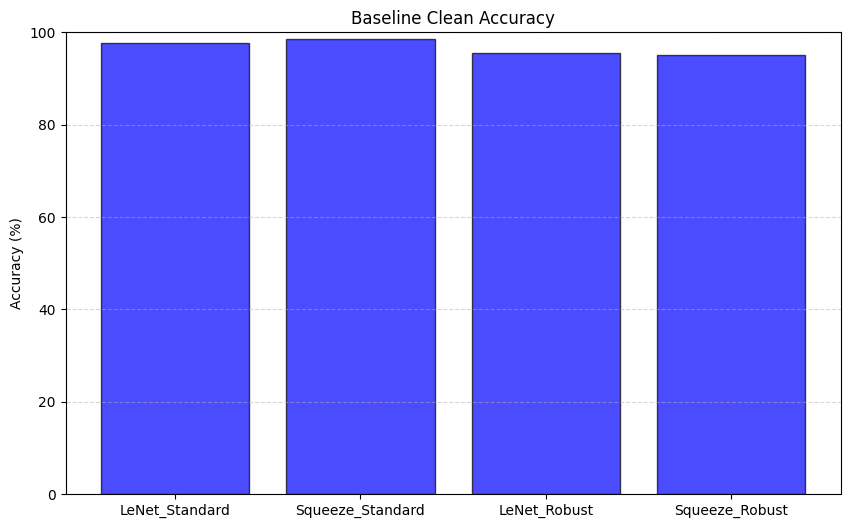

Baseline Clean Accuracy:
LeNet_Standard: 97.65%
Squeeze_Standard: 98.44%
LeNet_Robust: 95.40%
Squeeze_Robust: 95.04%


In [ ]:
x = np.arange(len(focus_models_names))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, clean_accs, color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Clean Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Baseline Clean Accuracy:")
for n, c in zip(focus_models_names, clean_accs):
    print(f"{n}: {c:.2f}%")

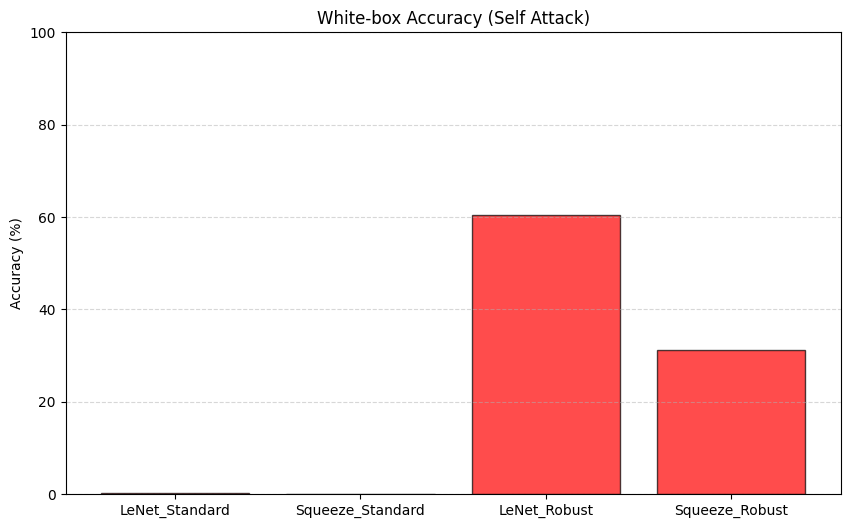

White-box Accuracy:
LeNet_Standard: 0.18%
Squeeze_Standard: 0.01%
LeNet_Robust: 60.46%
Squeeze_Robust: 31.23%


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, whitebox_accs, color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("White-box Accuracy (Self Attack)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("White-box Accuracy:")
for n, w in zip(focus_models_names, whitebox_accs):
    print(f"{n}: {w:.2f}%")

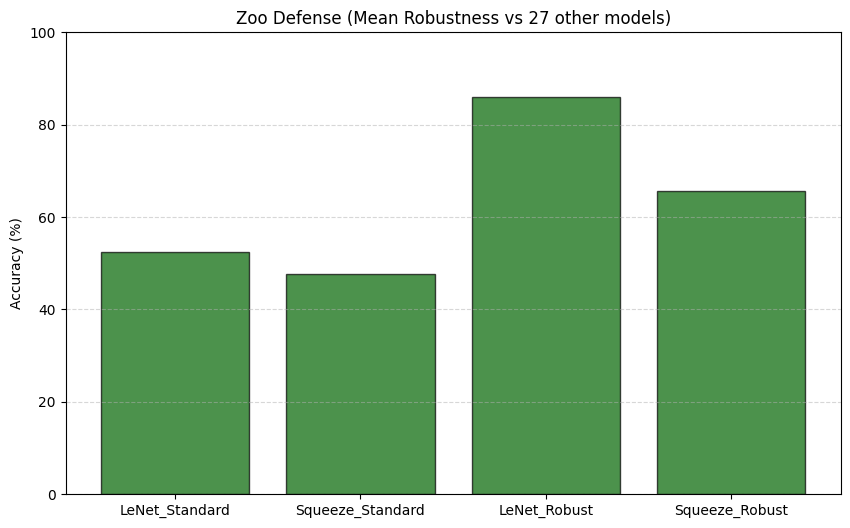

Zoo Defense Score:
LeNet_Standard: 52.49%
Squeeze_Standard: 47.71%
LeNet_Robust: 85.99%
Squeeze_Robust: 65.59%


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_defense_scores, color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title(f"Zoo Defense (Mean Robustness vs {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Zoo Defense Score:")
for n, d in zip(focus_models_names, zoo_defense_scores):
    print(f"{n}: {d:.2f}%")

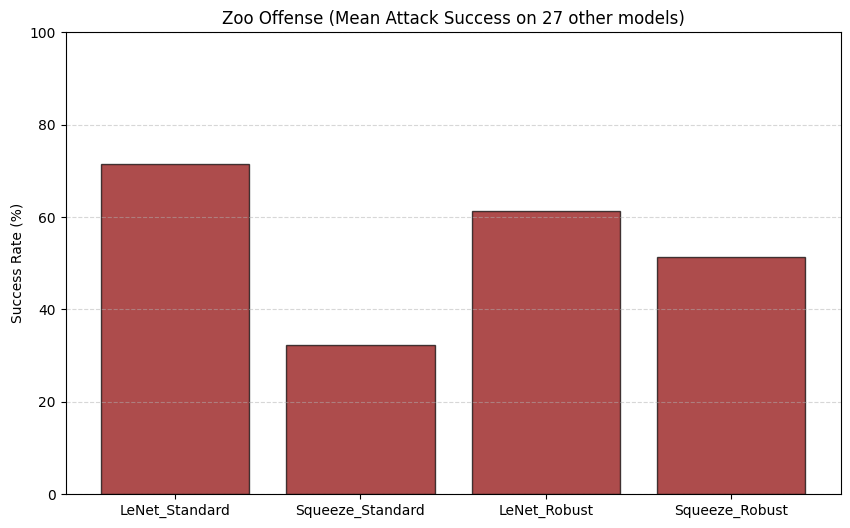

Zoo Offense Score:
LeNet_Standard: 71.53%
Squeeze_Standard: 32.25%
LeNet_Robust: 61.37%
Squeeze_Robust: 51.41%


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, zoo_offense_scores, color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title(f"Zoo Offense (Mean Attack Success on {n_models-1} other models)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Zoo Offense Score:")
for n, o in zip(focus_models_names, zoo_offense_scores):
    print(f"{n}: {o:.2f}%")

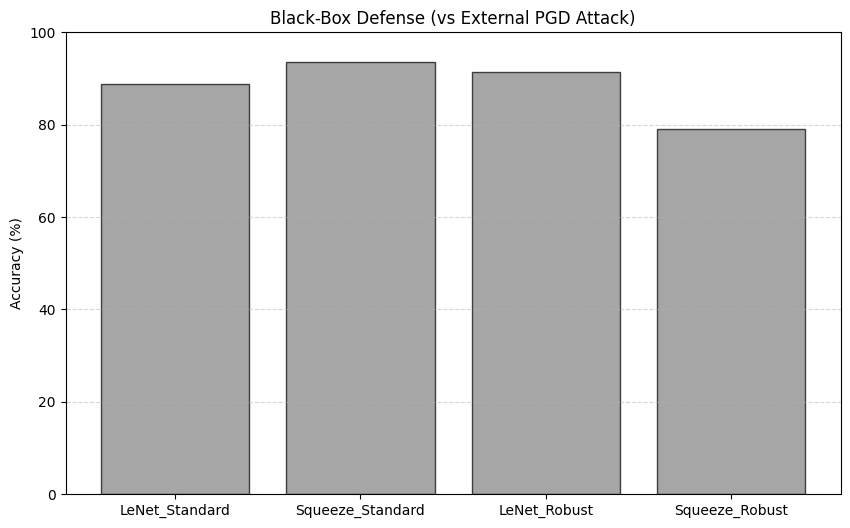

Black-Box Defense Data:
LeNet_Standard: 88.80%
Squeeze_Standard: 93.60%
LeNet_Robust: 91.30%
Squeeze_Robust: 79.00%


In [ ]:
x = np.arange(len(focus_models_names))

for attack_name, scores in blackbox_results.items():
    plt.figure(figsize=(10, 6))
    plt.bar(x, scores, color='gray', alpha=0.7, edgecolor='black')
    plt.xticks(x, focus_models_names)
    plt.ylabel("Accuracy (%)")
    plt.title(f"Black-Box Defense vs {attack_name.upper()}")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print(f"Results for {attack_name}:")
    for n, s in zip(focus_models_names, scores):
        print(f"{n}: {s:.2f}%")

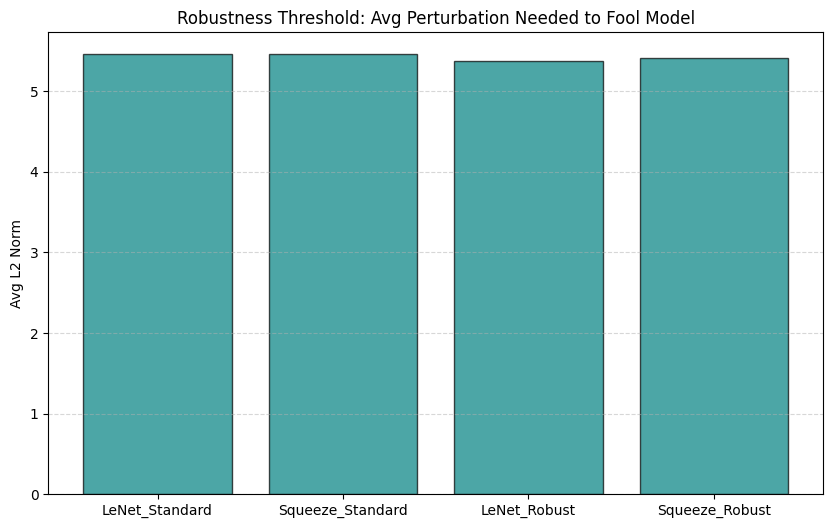

Avg Perturbation Data:
LeNet_Standard: 5.4533
Squeeze_Standard: 5.4578
LeNet_Robust: 5.3690
Squeeze_Robust: 5.4101


In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, avg_pert_scores, color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Robustness Threshold: Avg Perturbation Needed to Fool Model")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("Avg Perturbation Data:")
for n, p in zip(focus_models_names, avg_pert_scores):
    print(f"{n}: {p:.4f}")

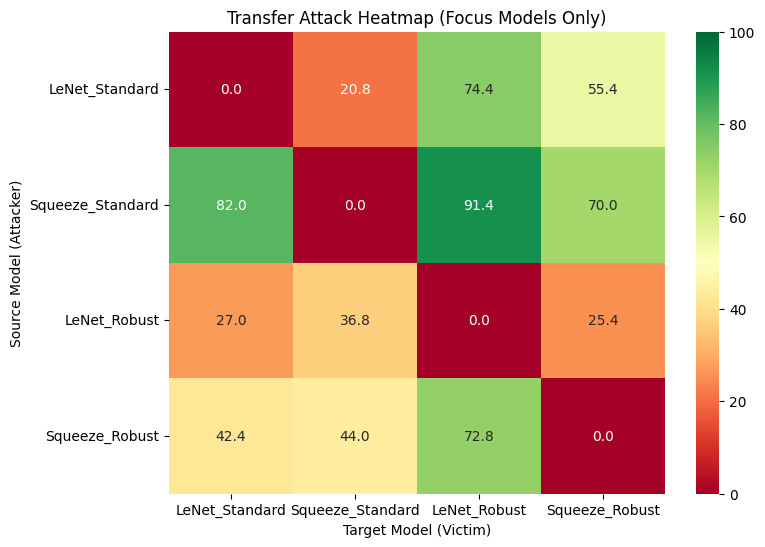

In [ ]:
focus_matrix = matrix_acc[np.ix_(focus_indices, focus_indices)]

plt.figure(figsize=(8, 6))
sns.heatmap(focus_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (Focus Models Only)")
plt.ylabel("Source Model (Attacker)")
plt.xlabel("Target Model (Victim)")
plt.show()

In [ ]:
from torchattacks import CW, Pixle

transform = transforms.Compose([transforms.ToTensor()])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
attack_configs = [
    ('CW', CW, {'c': 1, 'kappa': 0, 'steps': 50, 'lr': 0.01}),
    ('Pixle', Pixle, {'restarts': 10})
]

for atk_name, atk_class, atk_params in attack_configs:
    for name in all_names:
        fname = [x[1] for x in model_configs if x[0] == name][0]
        save_path = f"{adv_dir}/500_adv_{atk_name}_{fname}"

        if os.path.exists(save_path):
            continue

        model = zoo_models[name]
        try:
            adversary = atk_class(model, **atk_params)
        except:
            adversary = atk_class(model)

        adv_list, clean_list, lbl_list = [], [], []

        for data, target in test_loader:
            if len(adv_list) * 64 >= 500: break
            data, target = data.to(device), target.to(device)
            adv = adversary(data, target)
            adv_list.append(adv.cpu())
            clean_list.append(data.cpu())
            lbl_list.append(target.cpu())

        adv_imgs = torch.cat(adv_list)[:500]
        clean_imgs = torch.cat(clean_list)[:500]
        labels = torch.cat(lbl_list)[:500]

        with torch.no_grad():
            preds = model(adv_imgs.to(device)).argmax(1)
            rob_acc = (preds == labels.to(device)).float().mean().item() * 100

            clean_preds = model(clean_imgs.to(device)).argmax(1)
            clean_acc = (clean_preds == labels.to(device)).float().mean().item() * 100

        torch.save({
            'clean': clean_imgs,
            'adv': adv_imgs,
            'lbl': labels,
            'score_clean': clean_acc,
            'score_robust': rob_acc
        }, save_path)

In [ ]:
def calculate_metrics(attack_name):
    matrix_acc = np.zeros((n_models, n_models))
    matrix_pert = np.zeros((n_models, n_models))

    zoo_data = {}
    for name in all_names:
        fname = [x[1] for x in model_configs if x[0] == name][0]
        zoo_data[name] = torch.load(f"{adv_dir}/500_adv_{attack_name}_{fname}")

    for i, src_name in enumerate(all_names):
        data = zoo_data[src_name]
        adv = data['adv'].to(device)
        lbl = data['lbl'].to(device)
        clean = data['clean'].to(device)

        for j, tgt_name in enumerate(all_names):
            tgt_model = zoo_models[tgt_name]
            with torch.no_grad():
                preds = tgt_model(adv).argmax(1)
                acc = (preds == lbl).float().mean().item() * 100
                matrix_acc[i, j] = acc

                succ = (preds != lbl)
                if succ.sum() > 0:
                    diff = adv[succ] - clean[succ]
                    norms = diff.view(diff.size(0), -1).norm(p=2, dim=1)
                    matrix_pert[i, j] = norms.mean().item()

    results = {
        'clean': [], 'white': [], 'zoo_def': [], 'zoo_off': [],
        'bbox': {k: [] for k in external_datasets.keys()},
        'pert': [], 'matrix': matrix_acc
    }

    focus_indices = [all_names.index(n) for n in focus_models_names]

    for idx in focus_indices:
        name = all_names[idx]

        results['clean'].append(zoo_data[name]['score_clean'])
        results['white'].append(matrix_acc[idx, idx])

        incoming = [matrix_acc[i, idx] for i in range(n_models) if i != idx]
        results['zoo_def'].append(np.mean(incoming))

        outgoing = [100 - matrix_acc[idx, j] for j in range(n_models) if j != idx]
        results['zoo_off'].append(np.mean(outgoing))

        incoming_pert = [matrix_pert[i, idx] for i in range(n_models) if matrix_pert[i, idx] > 0]
        results['pert'].append(np.mean(incoming_pert) if incoming_pert else 0)

        for atk_k, (imgs, lbls) in external_datasets.items():
            with torch.no_grad():
                bb_preds = zoo_models[name](imgs.to(device)).argmax(1)
                acc = (bb_preds == lbls.to(device)).float().mean().item() * 100
                results['bbox'][atk_k].append(acc)

    return results

In [ ]:
cw_metrics = calculate_metrics('CW')

In [ ]:
x = np.arange(len(focus_models_names))
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['clean'], color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Clean Accuracy (CW Experiment)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['white'], color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("White-box Accuracy (CW)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['zoo_def'], color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Zoo Defense (CW)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['zoo_off'], color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title("Zoo Offense (CW)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
x = np.arange(len(focus_models_names))

for attack_name, scores in cw_metrics['bbox'].items():
    plt.figure(figsize=(10, 6))
    plt.bar(x, scores, color='gray', alpha=0.7, edgecolor='black')
    plt.xticks(x, focus_models_names)
    plt.ylabel("Accuracy (%)")
    plt.title(f"Black-Box Defense (CW Model) vs {attack_name.upper()}")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print(f"CW Results for {attack_name}:")
    for n, s in zip(focus_models_names, scores):
        print(f"{n}: {s:.2f}%")

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, cw_metrics['pert'], color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Avg Perturbation (CW)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
f_idx = [all_names.index(n) for n in focus_models_names]
sub_matrix = cw_metrics['matrix'][np.ix_(f_idx, f_idx)]
plt.figure(figsize=(8, 6))
sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (CW)")
plt.ylabel("Source")
plt.xlabel("Target")
plt.show()

In [ ]:
pixle_metrics = calculate_metrics('Pixle')

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['clean'], color='blue', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Clean Accuracy (Pixle Experiment)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['white'], color='red', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("White-box Accuracy (Pixle)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['zoo_def'], color='darkgreen', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Accuracy (%)")
plt.title("Zoo Defense (Pixle)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['zoo_off'], color='darkred', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Success Rate (%)")
plt.title("Zoo Offense (Pixle)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_results['pert'], color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Avg Perturbation Needed (Pixle)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
for n, v in zip(focus_models_names, pixle_results['pert']):
    print(f"{n}: {v:.4f}")

In [ ]:
x = np.arange(len(focus_models_names))

for attack_name, scores in pixle_metrics['bbox'].items():
    plt.figure(figsize=(10, 6))
    plt.bar(x, scores, color='gray', alpha=0.7, edgecolor='black')
    plt.xticks(x, focus_models_names)
    plt.ylabel("Accuracy (%)")
    plt.title(f"Black-Box Defense (Pixle Model) vs {attack_name.upper()}")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print(f"Pixle Results for {attack_name}:")
    for n, s in zip(focus_models_names, scores):
        print(f"{n}: {s:.2f}%")

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(x, pixle_metrics['pert'], color='teal', alpha=0.7, edgecolor='black')
plt.xticks(x, focus_models_names)
plt.ylabel("Avg L2 Norm")
plt.title("Avg Perturbation (Pixle)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [ ]:
sub_matrix = pixle_metrics['matrix'][np.ix_(f_idx, f_idx)]
plt.figure(figsize=(8, 6))
sns.heatmap(sub_matrix, annot=True, fmt=".1f", cmap="RdYlGn", vmin=0, vmax=100,
            xticklabels=focus_models_names, yticklabels=focus_models_names)
plt.title("Transfer Attack Heatmap (Pixle)")
plt.ylabel("Source")
plt.xlabel("Target")
plt.show()